In [1]:
import cv2
import os, random, string
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia
from PIL import ImageFont, ImageDraw, Image
# from parameter import *

In [2]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras import backend as K
from keras.optimizers import Adadelta,Adam,SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

K.set_learning_phase(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
		[
			# apply the following augmenters to most images
			# crop images by -5% to 10% of their height/width
			sometimes(iaa.CropAndPad(
				percent=(-0.01, 0.1),
				pad_mode=['constant', 'edge', 'median'],
				pad_cval=(0, 255)
			)),
			sometimes(iaa.Affine(
				scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images to 80-120% of their size, individually per axis
				translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -20 to +20 percent (per axis)
				rotate=(-5, 5), # rotate by -45 to +45 degrees
				shear=(-8, 8), # shear by -16 to +16 degrees
				order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
				cval=(0, 255), # if mode is constant, use a cval between 0 and 255
				mode=['constant', 'edge']# use any of scikit-image's warping modes (see 2nd image from the top for examples)
			)),
			# execute 0 to 5 of the following (less important) augmenters per image
			# don't execute all of them, as that would often be way too strong
			iaa.SomeOf((0, 5),
				[
	#                 sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 25))), # convert images into their superpixel representation
					iaa.OneOf([
						iaa.GaussianBlur((0, 2.0)), # blur images with a sigma between 0 and 3.0
						iaa.AverageBlur(k=(2, 4)), # blur image using local means with kernel sizes between 2 and 7
# 						iaa.MedianBlur(k=(3,5)), # blur image using local medians with kernel sizes between 2 and 7
					]),
					iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
					iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
					# search either for all edges or for directed edges,
					# blend the result with the original image using a blobby mask
					iaa.SimplexNoiseAlpha(iaa.OneOf([
						iaa.EdgeDetect(alpha=(0.3, 0.7)),
						iaa.DirectedEdgeDetect(alpha=(0.3, 0.7), direction=(0.0, 0.7)),
					])),
					# # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
					iaa.OneOf([
						iaa.Dropout((0.01, 0.05), per_channel=0.1), # randomly remove up to 10% of the pixels
# 						iaa.CoarseDropout((0.03, 0.05), size_percent=(0.01, 0.03), per_channel=0.1),
					]),
					# iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
					# iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
					# either change the brightness of the whole image (sometimes
					# per channel) or change the brightness of subareas
					iaa.OneOf([
						# iaa.Multiply((0.5, 1.5), per_channel=0.5),
						iaa.FrequencyNoiseAlpha(
							exponent=(-2, 0),
							first=iaa.Multiply((0.5, 1.5), per_channel=True),
							second=iaa.LinearContrast((0.5, 2.0))
						)
					]),
					iaa.LinearContrast((0.5, 1.0), per_channel=0.03), # improve or worsen the contrast
					sometimes(iaa.ElasticTransformation(alpha=(0.5, 2.0), sigma=0.15)), # move pixels locally around (with random strengths)
					sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.02))), # sometimes move parts of the image around
					sometimes(iaa.PerspectiveTransform(scale=0.05, keep_size=True))
				],
				random_order=True
			)
		],
		random_order=True
	)

In [5]:
CHARS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
         'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
         'W', 'X', 'Y', 'Z','',' ','_','.','/']
batch_size = 4
input_shape = (64,256)
num_classes = len(CHARS)+1

img_w, img_h = 256, 64

num_train_images = 50
num_validation_images = 5

val_batch_size =2

# downsample_factor = 8
max_text_len = 13

In [6]:
class TextImageGenerator(object):

	def __init__(self,batch_size,input_shape = (64,256),fonts_location = '/usr/share/fonts/truetype/freefont/'):
		# Define our sequence of augmentation steps that will be applied to every image
		# All augmenters with per_channel=0.5 will sample one value _per image_
		# in 50% of all cases. In all other cases they will sample new values
		# _per channel_.
		self.fonts_location = fonts_location
		self.batch_size = batch_size
		self.CHARS = CHARS

		self.CHARS_DICT = {char:i for i, char in enumerate(self.CHARS)}
		self.NUM_CHARS = len(self.CHARS)
		self.input_shape = input_shape
		
	def get_separator(self,fields = [""," "]):
		return random.choice(fields)

	def encode(self,s):
		label = np.zeros(shape=(max_text_len))
		for i,c in enumerate(s):
			label[i]=self.CHARS.index(c)
		return label

	def image_generator(self,state_code='KA',separator = [""," "] ):
		"""
		its a generator
		each call will give an image of random number plate with
		random image augmentation .
		"""
		fonts = [ImageFont.truetype(os.path.join(self.fonts_location,font_type),random.randint(34,40)) for font_type in os.listdir(self.fonts_location) ]

		font = random.choice(fonts) 
		single_line = True #random.choice([True,False])
		if single_line:
			number_plate = state_code+self.get_separator(separator)+str(random.randint(0,9))+str(random.randint(0,9))+\
			self.get_separator(separator)+random.choice(" "+string.ascii_uppercase)+random.choice(string.ascii_uppercase)+\
			self.get_separator(separator)+str(random.randint(0,9))+str(random.randint(0,9))+str(random.randint(0,9))+str(random.randint(0,9))
			if len(number_plate)<13:
				t = len(number_plate)
				for i in range(13-t):
					number_plate = number_plate+" "
		else :
			separator = separator +["\n"]
			number_plate = state_code+self.get_separator(separator)+str(random.randint(0,9))+str(random.randint(0,9))+\
			self.get_separator(separator)+random.choice(" "+string.ascii_uppercase)+random.choice(string.ascii_uppercase)+\
			self.get_separator(separator)+str(random.randint(0,9))+str(random.randint(0,9))+str(random.randint(0,9))+str(random.randint(0,9))
			#Creating an image with height,width  and color
		img = Image.new('RGB', (300,64), (random.randint(0,255),random.randint(0,255),random.randint(0,255)))
		
		draw = ImageDraw.Draw(img)
		draw.text((15,12), number_plate, (0,0,0), font=font)
		data =np.asarray(img)
        
# 		data=np.transpose(data,(1,0,2))
        
# 		data = data.astype(np.float32)
# 		data = (data / 255.0) * 2.0 - 1.0
        

		return data,number_plate

	def next_batch(self):
		while True:
			op = [self.image_generator() for i in range(self.batch_size)]
			input_length = np.ones((self.batch_size, 1)) * 30  #(img_w //64 - 3)  # (bs, 1)
			label_length = np.zeros((self.batch_size, 1))           # (bs, 1)
			input_X = seq(images = np.array([i[0] for i in op]))
            
			# input_X =  seq(np.array([i[0] for i in op]))
			input_X= input_X/255.0
            
			input_Y = np.array([self.encode(i[1]) for i in op])

			# imageX = input_X[0]
			# print(imageX.shape," ",input_X.shape)

			# img = Image.fromarray(imageX, 'RGB')

			# img.save('1.jpg')
			
			for i in range(len(op)):
				label_length[i]=len(op[i][1])


# 			inputs = {
# 					'the_input': input_X,  # (bs, 128, 64, 1)
# 					'the_labels': input_Y,  # (bs, 8)
# 					'input_length': input_length,  # (bs, 1) -> 모든 원소 value = 30
# 					'label_length': label_length  # (bs, 1) -> 모든 원소 value = 8
# 					}
			outputs = {'ctc': np.zeros([self.batch_size])}   # (bs, 1) -> 모든 원소 0
				
			return (input_X, outputs)


In [7]:
tiger_train = TextImageGenerator( batch_size, input_shape)
tiger_val = TextImageGenerator( batch_size, input_shape)

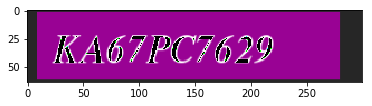

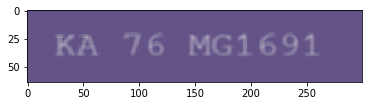

In [8]:
inp,out = tiger_train.next_batch()
for i in range(0,2):
    imageX=inp[i]*255.0
#     imageX = imageX.astype("int")
#     print(imageX)
#     img1 = Image.fromarray(imageX, 'RGB')
    plt.figure()
    plt.imshow(imageX)
    plt.savefig(str(i)+".png")
    plt.show()

In [166]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [167]:
def get_Model(training):

    inputs = Input(name ='the_input',shape=(320,64, 3))

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    print(inner.shape)
    # CNN to RNN
    inner = Reshape(target_shape=((32,2048)))(inner)  
    inner = Dense(64, activation='relu', kernel_initializer='he_normal')(inner)

    # RNN layer
    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal')(inner)  
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal')(inner)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  
    # lstm1_merged = BatchNormalization()(lstm1_merged)

    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) 
    
    print(inner.shape)

    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') 
    input_length = Input(name='input_length', shape=[1], dtype='int64')     
    label_length = Input(name='label_length', shape=[1], dtype='int64')     

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) 

    # print(y_pred,labels)
    # print(loss_out)

    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

In [168]:
model = get_Model(training=True)

W1209 11:02:12.900830 139882783496000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1209 11:02:13.114509 139882783496000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1209 11:02:13.302596 139882783496000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1209 11:02:13.303561 139882783496000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1209 11:02:14.057644 1398827834

(?, 40, 4, 512)


ValueError: total size of new array must be unchanged

In [169]:
model.summary()

NameError: name 'model' is not defined

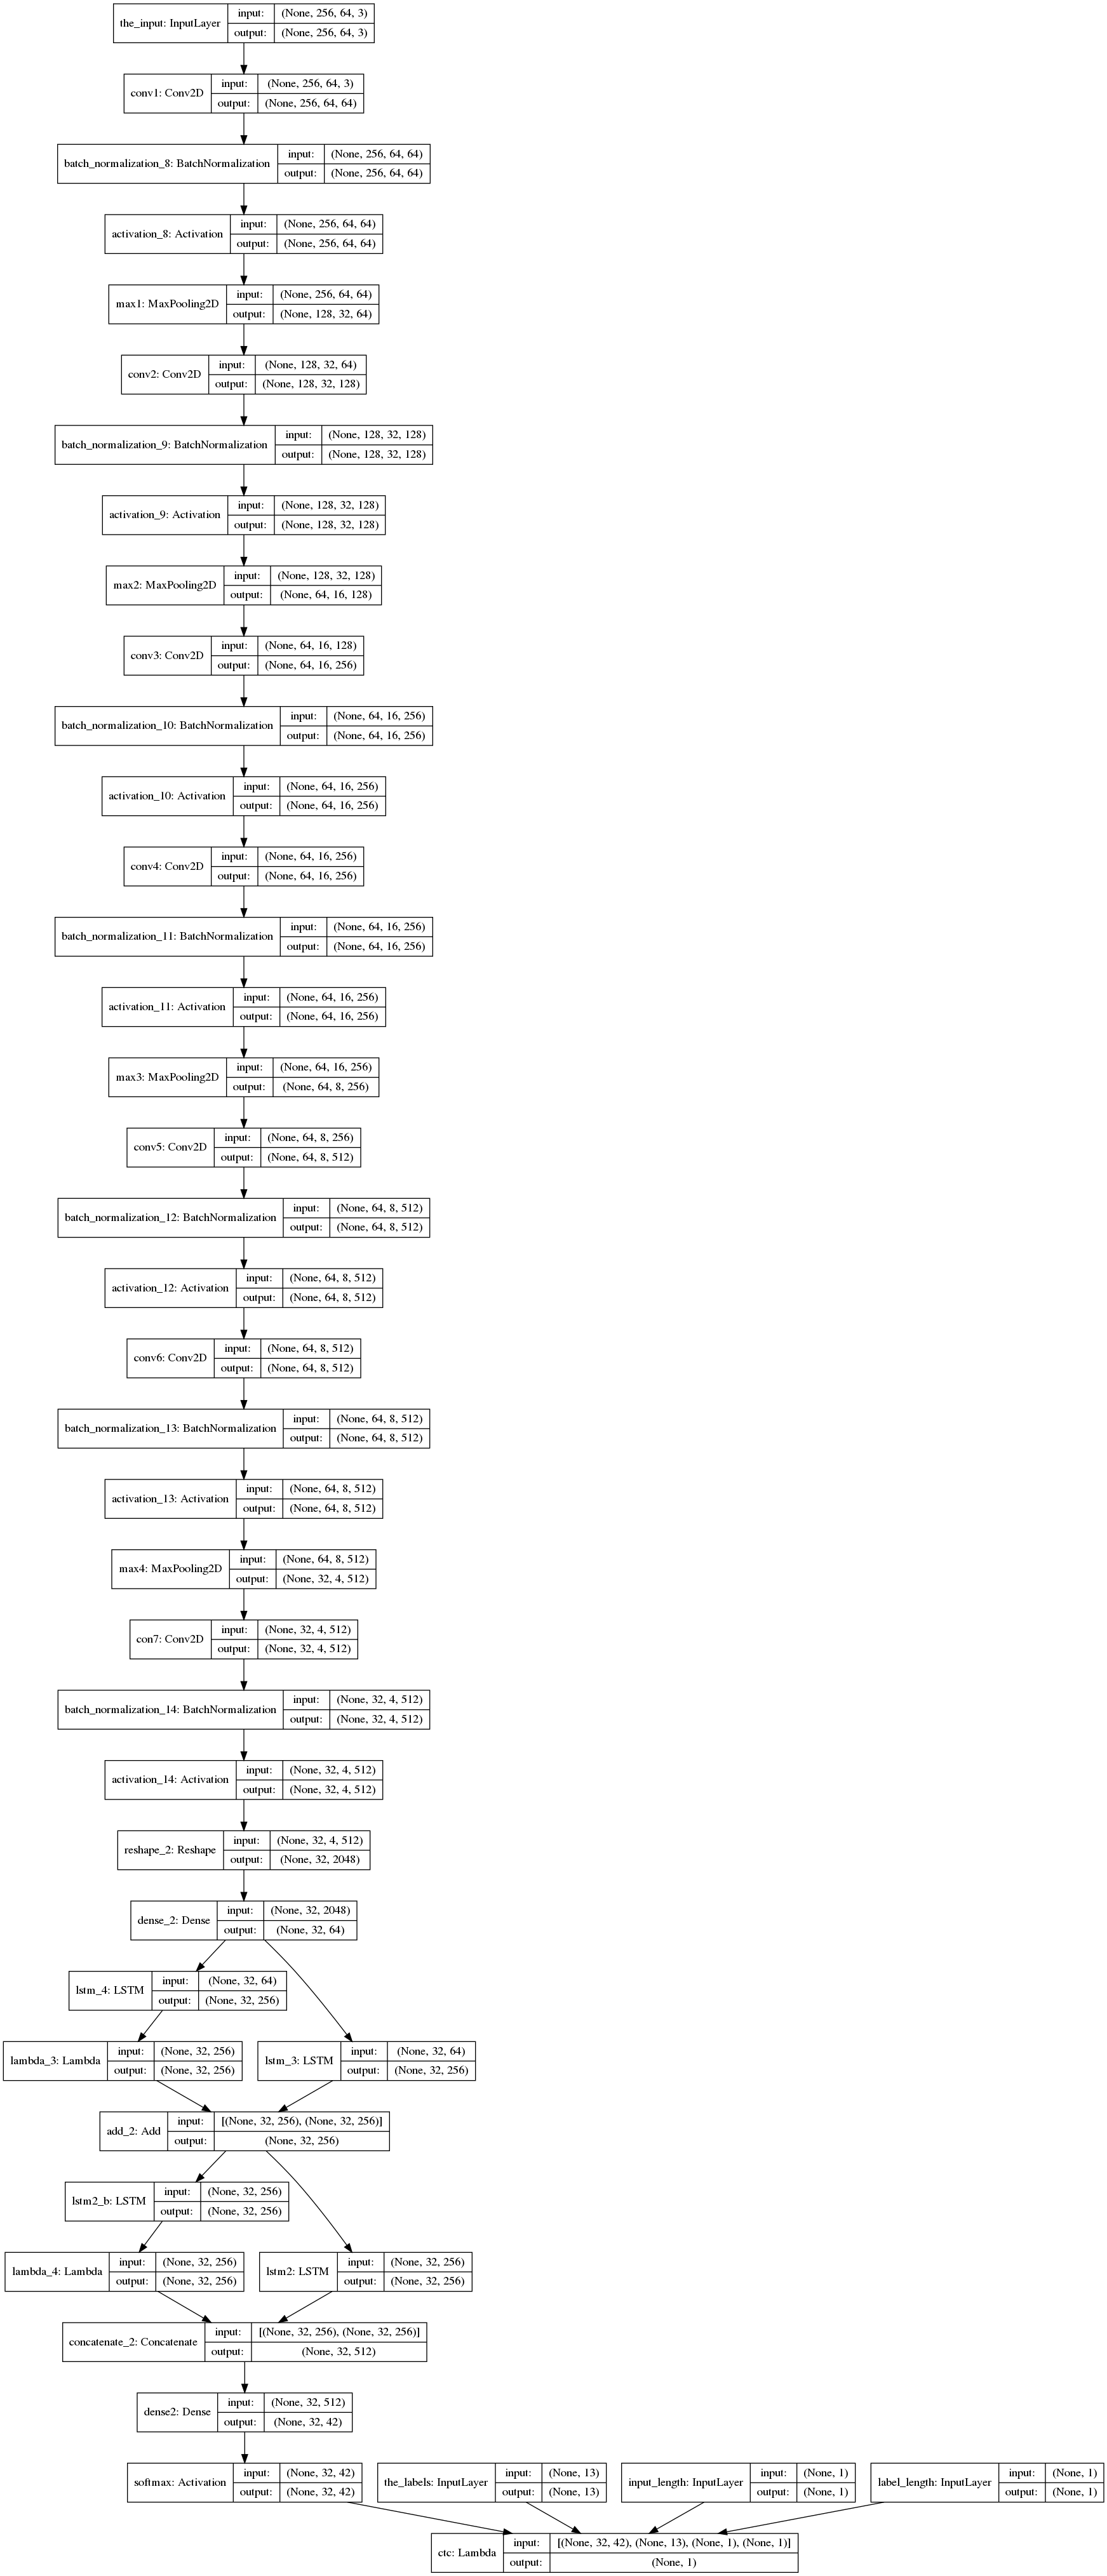

In [74]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [75]:
ada = Adadelta()

In [76]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='LSTM+BN6--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=ada)

In [77]:
from keras.callbacks import History 
history = History()

In [78]:
seqModel = model.fit_generator(generator=tiger_train.next_batch(),
                    steps_per_epoch=int(num_train_images / batch_size),
                    epochs=10,
                    verbose=2,
                    callbacks=[checkpoint],
                    validation_data=tiger_val.next_batch(),
                    validation_steps=int(num_validation_images/ val_batch_size))

Epoch 1/10
 - 35s - loss: 62.6166 - val_loss: 50.8975

Epoch 00001: saving model to LSTM+BN6--01--50.898.hdf5
Epoch 2/10
 - 20s - loss: 45.2978 - val_loss: 42.0572

Epoch 00002: saving model to LSTM+BN6--02--42.057.hdf5
Epoch 3/10
 - 19s - loss: 40.7118 - val_loss: 40.2427

Epoch 00003: saving model to LSTM+BN6--03--40.243.hdf5
Epoch 4/10
 - 19s - loss: 39.5814 - val_loss: 39.6965

Epoch 00004: saving model to LSTM+BN6--04--39.696.hdf5
Epoch 5/10
 - 19s - loss: 38.7465 - val_loss: 38.8557

Epoch 00005: saving model to LSTM+BN6--05--38.856.hdf5
Epoch 6/10
 - 19s - loss: 37.6678 - val_loss: 36.6284

Epoch 00006: saving model to LSTM+BN6--06--36.628.hdf5
Epoch 7/10
 - 20s - loss: 37.5172 - val_loss: 36.9473

Epoch 00007: saving model to LSTM+BN6--07--36.947.hdf5
Epoch 8/10
 - 19s - loss: 37.0685 - val_loss: 35.9657

Epoch 00008: saving model to LSTM+BN6--08--35.966.hdf5
Epoch 9/10
 - 19s - loss: 36.0543 - val_loss: 37.9833

Epoch 00009: saving model to LSTM+BN6--09--37.983.hdf5
Epoch 10/1

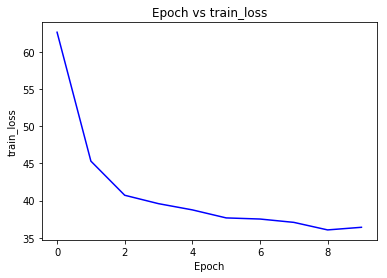

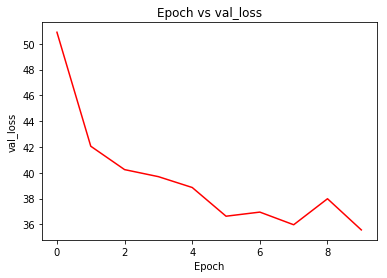

In [85]:
# print(hist.history)
train_loss = seqModel.history['loss']
val_loss   = seqModel.history['val_loss']
# train_acc  = seqModel.history['acc']
# val_acc    = seqModel.history['val_acc']
ep         = range(10)

plt.figure()
plt.plot(ep, train_loss,color='blue')
plt.xlabel('Epoch')
plt.ylabel('train_loss')
plt.title('Epoch vs train_loss')
plt.savefig("train_loss.png")

plt.figure()
plt.plot(xc, val_loss,color = 'red')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.title('Epoch vs val_loss')
plt.savefig("val_loss.png")